In [419]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [328]:
class Graph:
    def __init__(self):
        self.vertices = set()
        self.edges = {}
    
    def add_vertex(self, v):
        self.vertices.add(v)
    
    def add_edge(self, src, dst):
        if src in self.edges:
            self.edges[src] += [dst,]
        else:
            self.edges[src] = [dst,]
        if dst in self.edges:
            self.edges[dst] += [src,]
        else:
            self.edges[dst] = [src,]

In [380]:
data = np.loadtxt('data/p2p-Gnutella06.txt', delimiter='\t', skiprows=1, dtype=int)

g = Graph()
for vertex in np.unique(data):
    g.add_vertex(vertex)
for row in data:
    g.add_edge(row[0], row[1])

In [330]:
# graph of reduced size for debugging purposes
subgraph = data[np.where((data[:,0]<22) & (data[:,1]<22))[0]]
subgraph[1,0]=1
subgraph[2,0]=2
g = Graph()
for vertex in np.unique(subgraph):
    g.add_vertex(vertex)
for row in subgraph:
    g.add_edge(row[0], row[1])

In [331]:
def find_argmin(d):
    mini = 2**32
    for i, a_d in enumerate(d):
        if a_d < mini:
            idx = i
            mini = a_d
    return idx

In [332]:
def actual_distance(g, v):
  d = {v: 0}
  path = {}

  vertices = set(g.vertices)

  while vertices: 
    min_vrt = None
    for vrt in vertices:
      if vrt in d:
        if min_vrt is None:
          min_vrt = vrt
        elif d[vrt] < d[min_vrt]:
          min_vrt = vrt

    if min_vrt is None:
      break

    vertices.remove(min_vrt)
    crnt_weight = d[min_vrt]

    for a in g.edges[min_vrt]:
      weight = crnt_weight + 1
      if a not in d or weight < d[a]:
        d[a] = weight
        path[a] = min_vrt
  return d

In [333]:
def iBall(graph, src, max_d):
    result = {src: 0}
    queue = [src]
    d = 1
    current_level_degree = 1
    next_level_degree = 0
    while queue:
        crnt_vrt = queue.pop(0)
        current_level_degree -= 1
        if d >= max_d:
            del result[src]
            return result
        for neigh in graph.edges[crnt_vrt]:
            if neigh not in result:
                result[neigh] = d
                queue.append(neigh)
                next_level_degree += 1
        if current_level_degree == 0:
            current_level_degree = next_level_degree
            next_level_degree = 0
            d += 1
    del result[src]
    return result

In [382]:
class DistanceOracle:
    def __init__(self, g):
        n = len(g.vertices)
        threshold = n**-.5
        np.random.seed(440)
        self.L = [v for v in g.vertices if np.random.random() < threshold]
        self.L_dct = {}
        self.H_dct = {}
        for L in self.L:
            self.L_dct[L] = actual_distance(g, L)
        for vrt in g.vertices:
            if vrt not in self.L:
                n_L, min_L_u = self.find_nearest_L(vrt)
                self.H_dct[vrt] = iBall(g, vrt, min_L_u)
        print('init complete')
                
    def find_nearest_L(self, u):
        min_L_u = 2**32
        for L in self.L:
            L_u = self.L_dct[L][u]
            if L_u < min_L_u:
                min_L_u = L_u
                nearest_L = L
        return nearest_L, min_L_u
                
    def query_for_distance(self, u, v):
        if v in self.L_dct:
            return self.L_dct[v][u]
        elif u in self.L_dct:
            return self.L_dct[u][v]
        elif v in self.H_dct[u]:
            return self.H_dct[u][v]
        else:
            L, d = self.find_nearest_L(u)
            d = d + self.L_dct[L][v]
            return d

In [383]:
u, v=3, 19
start_t = time()
djk = actual_distance(g, u)
print('djk dist = {}, time = {}'.format(djk[v], time()- start_t))
start_t = time()
DO = DistanceOracle(g)
print('thurp dist = {}, time = {}'.format(DO.query_for_distance(u,v), time()- start_t))

djk dist = 4, time = 6.872175693511963
init complete
thurp dist = 6, time = 543.4879741668701


In [409]:
u, v=3, 19
start_t = time()
djk = actual_distance(g, u)
print('djk dist = {}, time = {}'.format(djk[v], time()- start_t))
start_t = time()
dst = DO.query_for_distance(u,v)
print('thurp dist = {}, time = {}'.format(dst, time()- start_t))

djk dist = 4, time = 6.97613000869751
thurp dist = 6, time = 0.00011157989501953125


In [474]:
start_t = time()
histogram = []
for v in g.vertices-set([u]):
    dst = DO.query_for_distance(u,v)
    histogram.append(dst/djk[v])
print('thurp dist = {}, time = {}'.format(dst, time()- start_t)) 

thurp dist = 5, time = 0.18351101875305176


In [519]:
test_v = np.random.choice(len(g.vertices), 100, replace=False)
hist_dct = {}
visited = []
for i in range(len(bins)):
    hist_dct[i] = 0
start_t = time()
for u in test_v:
    djk = actual_distance(g, u)
    for v in g.vertices-set([u]):
        if v in visited:
            continue
        dst = DO.query_for_distance(u,v) / djk[v]
        flag = True
        for i, abin in enumerate(bins[:-1]):
            if dst<bins[i+1]:
                hist_dct[i] += 1
                flag = False
                break
        if flag:
            hist_dct[i+1] += 1
    visited.append(u)
print('thurp dist = {}, time = {}'.format(dst, time()- start_t)) 

thurp dist = 1.4, time = 737.5442988872528


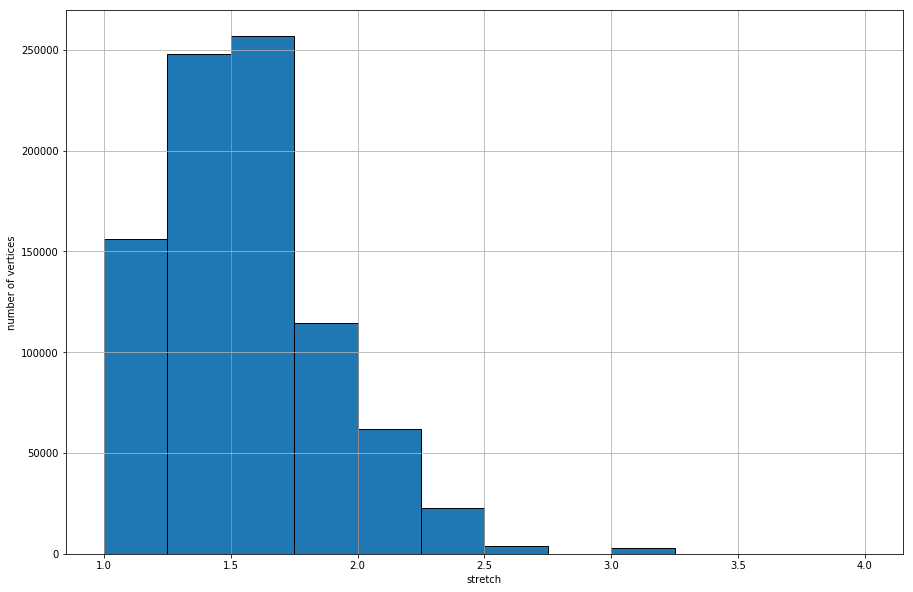

In [527]:
plt.figure(figsize=[15,10])
plt.bar(bins, hist_dct.values(), align='edge', edgecolor='black', width=.25)
plt.xlabel('stretch')
plt.ylabel('number of vertices')
plt.grid()
plt.show()

In [524]:
plt.bar(bins, hist_dct.values(), align='edge', edgecolor='black', width=.25)
plt.xlabel('stretch')
plt.ylabel('number of vertices')
plt.grid()
plt.savefig('hist.png', dpi=600)